# 모델 기본 세팅
## 라이브러리 로드 및 그래프 속성 지정

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 데이터 읽어오기
- 14개의 기온, 기압, 습도 등의 기후 데이터를 포함한 날씨 데이터를 구글 API에서 가져옴
- 09~16년도 데이터 사용

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


- 변수는 총 15개, 데이터는 약 42만개
## 모델 데이터 설계
- 특정 시점에서 지난 5일의 데이터를 사용하여 6시간 뒤의 온도를 예측하는 모형

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size, ) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [ ]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

# Univariate 모델
- 한 개의 Input
- 자기 자신의 과거 데이터를 통해 자신의 미래를 예측하는 모델
## 데이터 확인


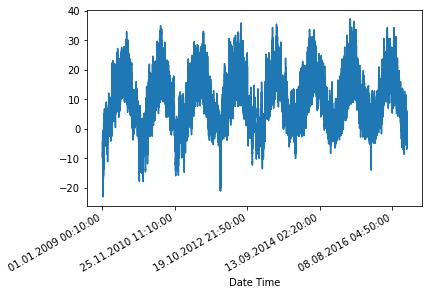

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()
uni_data.plot(subplots=True)
uni_data = uni_data.values

## 데이터 전처리
- normalize

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std

## 데이터 쪼개기
- 과거 20개의 데이터를 통해 다음 1개를 예측

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

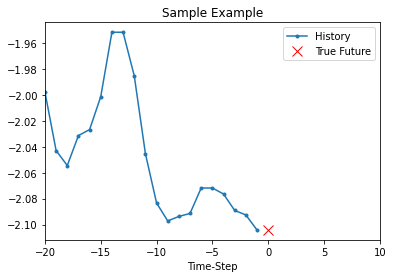

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, 
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, 
                                           univariate_past_history,
                                           univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

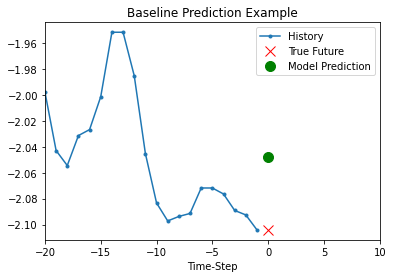

In [ ]:
def baseline(history):
    return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## LSTM 모델

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [ ]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

## 예측 후 확인

Epoch 1/10
200/200 [==============================] - 3s 6ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0444 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0199
Epoch 9/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0174

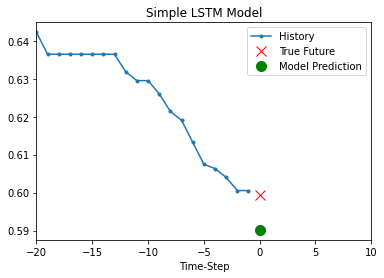

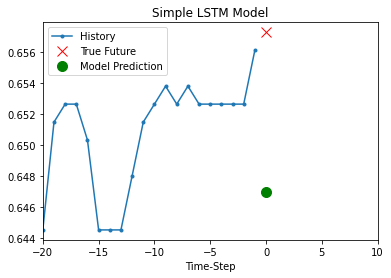

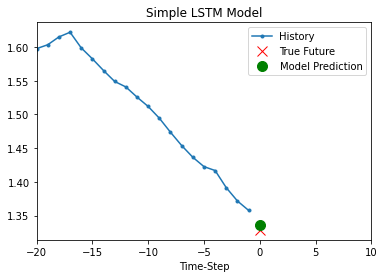

In [ ]:
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM Model')
    plt.show()

# Multivariate 모델

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3692b47690>,
      dtype=object)

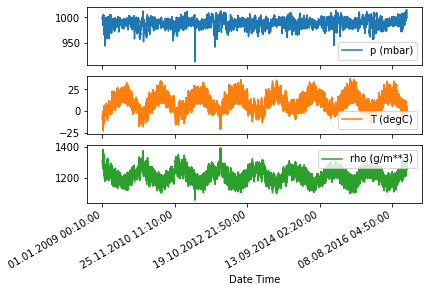

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.plot(subplots=True)

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset - data_mean) / data_std

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

In [ ]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

# Multivariate 모델 (Multi input, Multi output)

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [ ]:
print('Single window of past history: {}'.format(x_train_multi[0].shape))
print('\nTarget temperature to predict: {}'.format(y_train_multi[0].shape))


Single window of past history: (120, 3)

Target temperature to predict: (72,)


In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

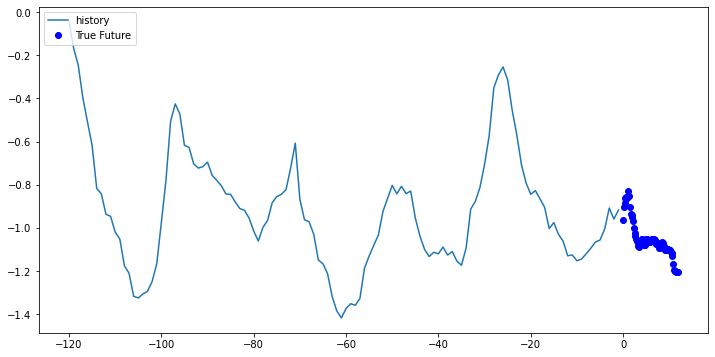

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='history')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


Epoch 1/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1879 - val_loss: 0.1886
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1856 - val_loss: 0.1879
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1919 - val_loss: 0.1910
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1868 - val_loss: 0.1779
Epoch 5/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1671 - val_loss: 0.1764
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1788 - val_loss: 0.1932
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1762 - val_loss: 0.1898
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1770 - val_loss: 0.1837
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1819 - val_loss: 0.1804
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.1755 - val_lo

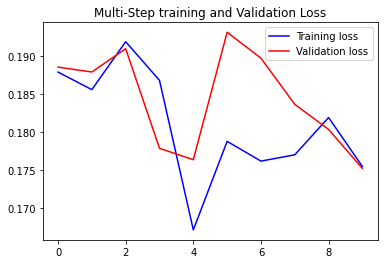

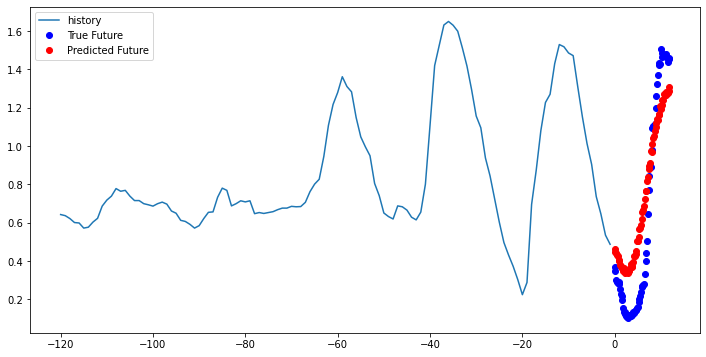

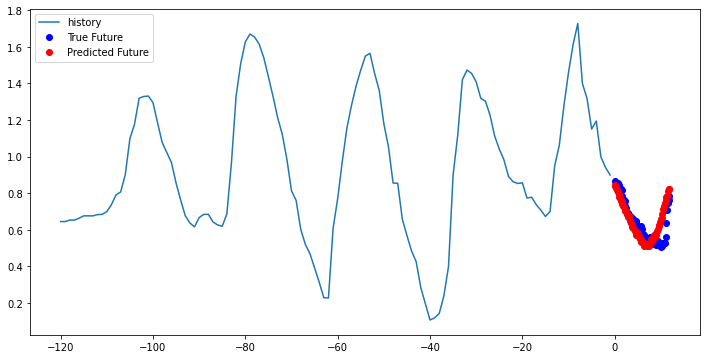

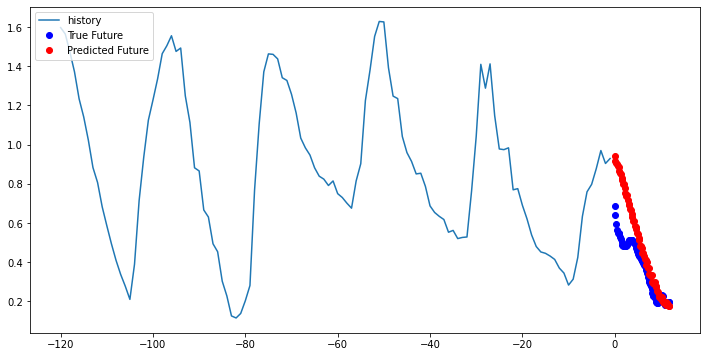

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
plot_train_history(multi_step_history, 'Multi-Step training and Validation Loss')

for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])